#MNIST Classification Multi-Layer Neural Network
The objective of this project was to build a multi-layer neural network for image classification of the MNIST dataset. Optimization techniques such as dropout, momentum, and a learning rate scheduler were used to further improve the training process.

This project was completed as part of coursework from the Master of Computer Science program at Arizona State University.

In [70]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [71]:
# Initialize seeds
np.random.seed(1)

# Get train and test datasets
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape to (d, m) where d is dimensions and m is number of samples
X_train = X_train.reshape(-1, 28*28).T
y_train = y_train.reshape(1, -1)
X_test = X_test.reshape(-1, 28*28).T
y_test = y_test.reshape(1, -1)

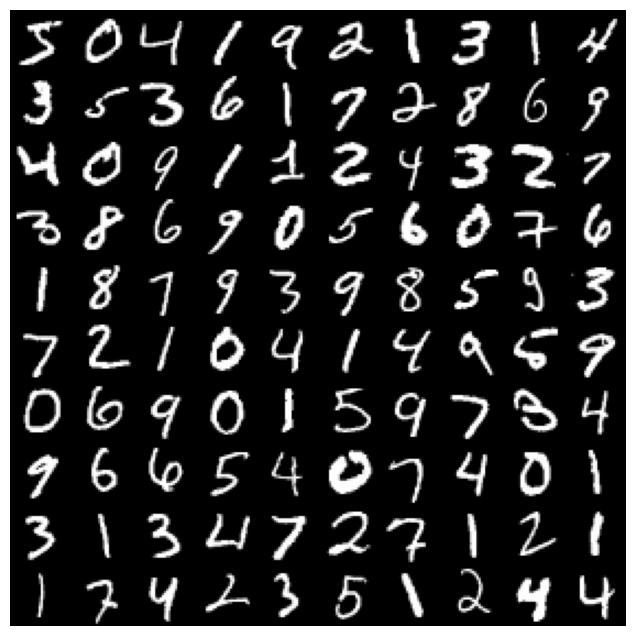

In [72]:
# Display some images
x_data = np.concatenate((X_train[:,:50],X_test[:,:50]), axis=1).reshape(28,28,10,10).transpose(2,0,3,1).reshape(28*10,-1)

plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(x_data, cmap='gray')

ReLU was used as the activation function after each layer. The equation for ReLU is as follows, where Z is the input to the activation function:

$$
ReLU(Z) = \max(0, Z)
$$



The derivative equation will also be needed to perform backpropagation. The equation is as follows:

$$
\frac{{ReLU(Z)}}{{dZ}} =
\begin{cases}
1 & \text{if } Z > 0 \\
0 & \text{if } Z \leq 0
\end{cases}
$$

In [73]:
# ReLU activation function
#    Z: output of the previous layer and input to ReLU
#    A: output of ReLU
#    cache: dictionary to hold input
def relu(Z):
  cache = {}
  cache["Z"] = Z
  A = np.maximum(0,Z)
  return A, cache

# ReLU gradient function to compute derivative of ReLU activation
#    dA: derivative of previous layer according to the chain rule
#    dZ: derivative of ReLU
def relu_der(dA, cache):
  dZ = np.array(dA, copy=True)
  Z = cache["Z"]
  dZ[Z < 0] = 0
  dZ[Z > 0] = 1
  dZ = dZ * dA
  return dZ

In [74]:
# Computes the linear activation of input Z (done for completeness)
def linear(Z):
  A = Z
  cache = {}
  cache["Z"] = Z
  return A, cache

# Computes derivative for linear activation (done for completeness)
def linear_der(dA, cache):
  dZ = np.array(dA, copy=True)
  return dZ

For the last layer in the neural network, the softmax activation function was used to obtain a probability distribution of the class labels, choosing the label with the maximum probability as the predicted class label. A shifted softmax was utilized to keep the values low and gain numerical stability.

$$
a_{k}(i) = \frac{e^{z_k^i - z_{\text{max}}}}{\sum_{k=1}^{n} e^{z_k^i - z_{\text{max}}}} \hspace{1cm} \text{for 1} \leq k \leq n
$$

The loss function was cross entropy loss, since we we need a probability distribution of multiple classes to label the digit images. The equation is calculated as follows:

$$
\text{Loss}(A, Y) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{n} I\{y^i = k\} \log(a_k^i)
$$

where the $I$ is an identity function:

$$
I\text{{condition} = 1, if condition = True}
$$
$$
I\text{{condition} = 0, if condition = False}
$$

To calculate the derivative for backpropagation, it is easier and more stable to compute $\frac{dL}{dZ}$, where $dZ$ is the input to the softmax function, rather than $\frac{dL}{dA}$, where $dA$ is the output of the softmax function. The derivative is as follows:

$$
dZ = \frac{1}m(A - \widehat{Y})
$$

where $\widehat{Y}$ is the one-hot encoding representation of the true labels and $A$ is the matrix of softmax activations.

In [75]:
# Calculate softmax and cross entropy loss
#   Z: inputs to the softmax
#   Y: labels
#   A: softmax activations
#   loss: loss values
def softmax_cross_entropy_loss(Z, Y=np.array([])):
  m = Z.shape[1]
  maxZ = np.max(Z)
  A = np.exp(Z - maxZ) / np.sum(np.exp(Z - maxZ), axis=0, keepdims=True)
  I = np.zeros(A.shape)
  I[Y.astype(int),np.arange((Y.size))] = 1
  loss = -np.sum(I*np.log(A)) / m

  cache = {}
  cache["A"] = A
  return A, cache, loss

# Derivative of cross entropy loss w.r.t softmax inputs
#   Y: labels
#   dZ: derivative of loss with respect to softmax output
def softmax_cross_entropy_loss_der(Y, cache):
  A = cache["A"]
  m = A.shape[1]
  I = np.zeros(A.shape)
  I[Y.astype(int),np.arange((Y.size))] = 1
  dZ = (A - I) / m

  return dZ

The dropout layer was added to improve regularization. Dropout is only applied during training, and not testing. To perform dropout, a mask was used to convert random values to 0. For backpropagation, the mask is reapplied to ensure the appropriate values are masked for better training.

In [76]:
# Apply dropout to values
#   A: activation input before dropout
#   drop_prob: dropout probability
#   mode: whether training/testing is occurring
def dropout(A, drop_prob, mode='train'):
  mask = None
  if drop_prob == 0:
    cache = (drop_prob, mode, mask)
    return A, cache
  prob_keep = 1-drop_prob
  if mode == 'train':
    mask = (np.random.rand(A.shape[0],A.shape[1])<prob_keep) / prob_keep
    A = A * mask
  elif mode != 'test':
    raise ValueError("Mode value is incorrect. Set it to 'train' or 'test'")
  cache = (drop_prob, mode, mask)
  return A, cache

# Derivative of dropout layer
#   dA_in: derivative from upper layers
#   dA_out: derivative of dropout
def dropout_der(dA_in, cache):
  dA_out = None
  drop_out, mode, mask = cache
  if not drop_out:
    return dA_in
  if mode == 'train':
    dA_out = dA_in * mask
  elif mode == 'test':
    dA_out = dA_in
  return dA_out

Batchnorm normalizes inputs to improve training.

In [77]:
# Batchnorm
#   A: activation outputs
#   beta: mean
#   gamma: standard deviation
#   Anorm: normalized values
def batchnorm(A, beta, gamma):
  if beta.size == 0 or gamma.size == 0:
    cache = {}
    return A, cache
  epsilon = 1e-5
  m = A.shape[1]
  mean = np.sum(A, axis=1, keepdims=True) / m
  variance = np.sum((A - mean)**2, axis=1, keepdims=True) / m
  Anorm = (A - mean) / np.sqrt(variance + epsilon)
  Anorm = gamma * Anorm + beta
  cache = gamma, mean, variance, A, epsilon
  return Anorm, cache

# Batchnorm derivative for backpropagation
#   dA_in: derivative from upper layers
#   dA_out: derivative of batchnorm layer
def batchnorm_der(dA_in, cache):
  if not cache:
    dbeta = []
    dgamma = []
    return dA_in, dbeta, dgamma

  gamma, mean, variance, A, epsilon = cache
  m = dA_in.shape[1]
  xmean = A - mean
  onesArr = np.ones((dA_in.shape))
  Anorm = (A - mean) / np.sqrt(variance + epsilon)
  sqrtVarEps = np.sqrt(variance+epsilon)
  dvariance = 0.5 * (1/sqrtVarEps) * (-1/(sqrtVarEps**2)) * np.sum(dA_in * gamma * xmean, axis=1, keepdims=True)
  dmean = -1 * np.sum((dA_in * gamma * (1 / sqrtVarEps)) + ((2/m) * xmean * onesArr * dvariance), axis=1, keepdims=True)

  dA_out = ((dA_in * gamma * (1 / sqrtVarEps)) + ((2/m) * xmean * onesArr * dvariance)) + ((1/m) * onesArr * dmean)
  dbeta = np.sum(dA_in, axis=1, keepdims=True)
  dgamma = np.sum(dA_in*Anorm, axis=1, keepdims=True)
  return dA_out, dbeta, dgamma

Initialize parameters of the multi-layer neural network. These parameters are stored in a dictionary so that they can easily be stored and accessed as needed.

Kaiming He initialization was used to initialize the weights. The formala is as follows:

$$
w=np.random.randn(n_{out},n_{in})∗(2./np.sqrt(n_{in}))
$$

In [78]:
# Initialize parameters
#   net_dims: list containing the dimensions of the network
#   act_list: list of strings for activations
#   drop_prob_list: list of dropout probabilities
def initialize_network(net_dims, act_list, drop_prob_list):
  net_dims_len = len(net_dims)
  parameters = {}
  parameters['numLayers'] = net_dims_len - 1;
  for l in range(net_dims_len-1):
      parameters["act"+str(l+1)] = act_list[l]
      parameters["dropout"+str(l+1)] = drop_prob_list[l]
      parameters["W"+str(l+1)] = np.random.randn(net_dims[l+1],net_dims[l]) * (2. / np.sqrt(net_dims[l]))
      parameters["b"+str(l+1)] = np.zeros((net_dims[l+1],1))
  return parameters

Adam with momentum was used as the optimization algorithm, which consists of a velocity $V$ parameters and gradient-squares $G$ parameters. Here we initialize them.

In [79]:
# Initialize V and G parameters for Adam optimization
def initialize_velocity(parameters, apply_momentum=True):
  L = parameters['numLayers']
  parameters['apply_momentum'] = apply_momentum

  for l in range(L):
    if apply_momentum:
      parameters["VdW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
      parameters["Vdb" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
      parameters["GdW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
      parameters["Gdb" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
  return parameters

Additionally, we initialize the batchnorm parameters (beta and gamma) and their corresponding velocity and gradient-squares values. Only the hidden layers have batchnorm parameters.

In [80]:
# Initialize batchnorm parameters for hidden layers
def initialize_bnorm_params(parameters, bnorm_list, apply_momentum):
  L = parameters['numLayers']
  parameters['bnorm_list'] = bnorm_list

  for l in range(L):
    if bnorm_list[l]:
      n = parameters["W" + str(l+1)].shape[0]
      parameters['bnorm_beta'+str(l+1)] = np.random.randn(n,1)
      parameters['bnorm_gamma'+str(l+1)] = np.random.randn(n,1)
      if apply_momentum:
        parameters['Vbnorm_beta'+str(l+1)] = np.zeros((n,1))
        parameters['Gbnorm_beta'+str(l+1)] = np.zeros((n,1))
        parameters['Vbnorm_gamma'+str(l+1)] = np.zeros((n,1))
        parameters['Gbnorm_gamma'+str(l+1)] = np.zeros((n,1))
    else:
      parameters['bnorm_beta'+str(l+1)] = np.asarray([])
      parameters['Vbnorm_beta'+str(l+1)] = np.asarray([])
      parameters['Gbnorm_beta'+str(l+1)] = np.asarray([])
      parameters['bnorm_gamma'+str(l+1)] = np.asarray([])
      parameters['Vbnorm_gamma'+str(l+1)] = np.asarray([])
      parameters['Gbnorm_gamma'+str(l+1)] = np.asarray([])
  return parameters

The forward propagation equation is as follows:

$$
Z=WA\_prev+b
$$

where $A\_prev$ is the input to the current layer.

Once the output is obtained, the values go through the activation function, batchnorm layer, and dropout layer respectively.

Finally, the entire multi-layer forward propagation is implemented.

In [81]:
# Calculate forward
def linear_forward(A_prev, W, b):
  Z = np.dot(W, A_prev) + b

  cache = {}
  cache["A"] = A_prev
  return Z, cache

# Perform forward propagation
def layer_forward(A_prev, W, b, activation, drop_prob, bnorm_beta, bnorm_gamma, mode):
  Z, lin_cache = linear_forward(A_prev, W, b)
  if activation == "relu":
    A, act_cache = relu(Z)
  elif activation == "linear":
    A, act_cache = linear(Z)

  A, bnorm_cache = batchnorm(A, bnorm_beta, bnorm_gamma)
  A, drop_cache = dropout(A, drop_prob, mode)
  cache = {}
  cache["lin_cache"] = lin_cache
  cache["act_cache"] = act_cache
  cache["bnorm_cache"] = bnorm_cache
  cache["drop_cache"] = drop_cache

  return A, cache

# Propagate through every layer in the network
def multi_layer_forward(A0, parameters, mode):
  L = parameters['numLayers']
  A = A0
  caches = []
  for l in range(L):
    A, cache = layer_forward(A, parameters["W"+str(l+1)], parameters["b"+str(l+1)],
                             parameters["act"+str(l+1)], parameters["dropout"+str(l+1)],
                             parameters['bnorm_beta'+str(l+1)], parameters['bnorm_gamma'+str(l+1)],
                             mode)
    caches.append(cache)
  return A, caches

Backpropagation through the linear layer consists of three equations:

$$dA\_prev=W^TdZ$$
$$dW=dZA^T$$
$$db=∑_{i=1}^mdZ^{(i)}$$

With this linear layer backpropagation, we will then perform backpropagation for an entire layer, starting from the dropout and followed by batchnorm, activation function, and linear layer respectively. We are reversing the order from forward propagation. Finally, we create a function that performs mult-layer backpropagation, starting from the final layer.

In [82]:
# Backpropagation through a single linear layer
#   dZ: derivative of dL/dZ
#   dA_prev: derivative of previous layer
#   dW: gradient of W
#   db: gradient of b
def linear_backward(dZ, cache, W, b):
  A = cache["A"]
  dA_prev = np.dot(W.T, dZ)
  dW = np.dot(dZ, A.T)
  db = np.sum(dZ, axis=1, keepdims=True)

  return dA_prev, dW, db

# Backpropagation through a layer
def layer_backward(dA, cache, W, b, activation):
  lin_cache = cache["lin_cache"]
  act_cache = cache["act_cache"]
  drop_cache = cache["drop_cache"]
  bnorm_cache = cache["bnorm_cache"]

  dA = dropout_der(dA, drop_cache)
  dA, dbnorm_beta, dbnorm_gamma = batchnorm_der(dA, cache["bnorm_cache"])
  if activation == "relu":
    dZ = relu_der(dA, act_cache)
  elif activation == "linear":
    dZ = linear_der(dA, act_cache)

  dA_prev, dW, db = linear_backward(dZ, lin_cache, W, b)
  return dA_prev, dW, db, dbnorm_beta, dbnorm_gamma

# Perform multi-layer backpropagation
#   dAL: derivatives from cross entropy layer
def multi_layer_backward(dAL, caches, parameters):
  L = len(caches)
  gradients = {}
  dA = dAL
  activation = "linear"
  for l in reversed(range(L)):
    dA, gradients["dW"+str(l+1)], gradients["db"+str(l+1)], \
                        gradients["dbnorm_beta"+str(l+1)], \
                        gradients["dbnorm_gamma"+str(l+1)] = \
                        layer_backward(dA, caches[l], parameters["W"+str(l+1)], \
                        parameters["b"+str(l+1)], parameters["act"+str(l+1)])
  return gradients

The Adam with momentum algorithm includes mulitple equations, starting with velocity $V$, which keeps track of the direction of past gradients to determine the direction of the parameters updates. The equation is seen below:

$$
V_{t+1}=βV_{t}+(1−β)∇J(θ_t)
$$

The calculation of gradient-squares $G$ is the next equation, which adjusts the learning rates for each parameter based on the variance of the gradients.

$$
G_{t+1}=β_2G_t+(1−β_2)∇J(θ_t)^2
$$

And finally, the parameter update equation:

$$
θ_{t+1}=θ_t−\frac{α}{\sqrt{G_{t+1}+ε}}V_{t+1} \hspace{1cm} θ∈\{W,b\}
$$

In [83]:
# Compute parameter update with Adam momentum
#   parameters: dictionary of network parameters
#   gradients: dictionary of gradients of network parameters
def update_parameters_with_momentum_Adam(parameters, gradients, alpha, beta=0.9, beta2=0.99, eps=1e-8):
  L = parameters['numLayers']
  apply_momentum = parameters['apply_momentum']
  bnorm_list = parameters['bnorm_list']

  for l in range(L):
    if apply_momentum:
      parameters["VdW" + str(l+1)] = beta * parameters["VdW" + str(l+1)] \
                      + (1-beta) * gradients["dW"+str(l+1)]
      parameters["Vdb" + str(l+1)] = beta * parameters["Vdb" + str(l+1)] \
                      + (1-beta) * gradients["db"+str(l+1)]
      parameters["GdW" + str(l+1)] = beta2 * parameters["GdW" + str(l+1)] \
                      + (1-beta2) * (gradients["dW"+str(l+1)]**2)
      parameters["Gdb" + str(l+1)] = beta2 * parameters["Gdb" + str(l+1)] \
                      + (1-beta2) * (gradients["db"+str(l+1)]**2)
      parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (alpha \
                      / (np.sqrt(parameters["GdW" + str(l+1)] \
                      + eps))) * parameters["VdW" + str(l+1)]
      parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (alpha \
                      / (np.sqrt(parameters["Gdb" + str(l+1)] + eps))) \
                      * parameters["Vdb" + str(l+1)]

    else:
        parameters["W"+str(l+1)] -= alpha * gradients["dW"+str(l+1)]
        parameters["b"+str(l+1)] -= alpha * gradients["db"+str(l+1)]

    if apply_momentum and bnorm_list[l]:
      parameters['Vbnorm_beta'+str(l+1)] = beta*parameters['Vbnorm_beta'+str(l+1)] \
                + (1 - beta)*gradients["dbnorm_beta"+str(l+1)]
      parameters['Vbnorm_gamma'+str(l+1)] = beta*parameters['Vbnorm_gamma'+str(l+1)] \
                + (1 - beta)*gradients["dbnorm_gamma"+str(l+1)]
      parameters['Gbnorm_beta'+str(l+1)] = beta2*parameters['Gbnorm_beta'+str(l+1)] \
                + (1 - beta2)*(gradients["dbnorm_beta"+str(l+1)]**2)
      parameters['Gbnorm_gamma'+str(l+1)] = beta2*parameters['Gbnorm_gamma'+str(l+1)] \
                + (1 - beta2)*(gradients["dbnorm_gamma"+str(l+1)]**2)
      parameters['bnorm_beta' + str(l+1)] = parameters['bnorm_beta' + str(l+1)] \
                - alpha*parameters['Vbnorm_beta'+str(l+1)]/np.sqrt(parameters['Gbnorm_beta'+str(l+1)] + eps)
      parameters['bnorm_gamma' + str(l+1)] = parameters['bnorm_gamma' + str(l+1)] \
                - alpha*parameters['Vbnorm_gamma'+str(l+1)]/np.sqrt(parameters['Gbnorm_gamma'+str(l+1)] + eps)
    elif bnorm_list[l]:
      parameters['bnorm_beta' + str(l+1)] -= alpha * gradients["dbnorm_beta"+str(l+1)]
      parameters['bnorm_gamma' + str(l+1)] -= alpha * gradients["dbnorm_beta"+str(l+1)]

  return parameters

Assemble all the componenets of the multi-layer neural network and define the training loop.

In [84]:
# Build the multi-layer neural network
#   X: training data
#   Y: training data labels
#   net_dims: tuple of layer dimensions
#   act_list: list of activation functions
#   drop_prob_list: list of dropout probabilities
#   bnorm_list: binary list for presence or absence of batchnorm
#   num_epochs: number of epochs to train
#   batch_size: batch size for training
#   learning_rate: learning rate for gradient descent
#   decay_rate: rate of learning rate decay
#   apply_momentum: presence or absence of momentum
#   costs: list of losses over training
def multi_layer_network(X, Y, net_dims, act_list, drop_prob_list, bnorm_list, num_epochs=3,
                        batch_size=64, learning_rate=0.2, decay_rate=0.01, apply_momentum=True, log=True, log_step=200):
  mode = 'train'
  n, m = X.shape
  parameters = initialize_network(net_dims, act_list, drop_prob_list)
  parameters = initialize_velocity(parameters, apply_momentum)
  parameters = initialize_bnorm_params(parameters, bnorm_list, apply_momentum)
  costs = []
  itr = 0
  for epoch in range(num_epochs):
    alpha = learning_rate*(1/(1+decay_rate*epoch))
    if log:
      print('------- Epoch {} -------'.format(epoch+1))
    for ii in range((m - 1) // batch_size + 1):
      Xb = X[:, ii*batch_size : (ii+1)*batch_size]
      Yb = Y[:, ii*batch_size : (ii+1)*batch_size]
      A0 = Xb

      A, caches = multi_layer_forward(A0,parameters,mode)
      AL, softmax_cache, cost = softmax_cross_entropy_loss(A,Yb)
      dAL = softmax_cross_entropy_loss_der(Yb,softmax_cache)
      gradients = multi_layer_backward(dAL,caches,parameters)
      parameters = update_parameters_with_momentum_Adam(parameters,gradients,alpha)

      if itr % log_step == 0:
        costs.append(cost)
        if log:
          print("Iteration %i: Loss - %.05f | Learning Rate: %.05f" %(itr, cost, alpha))
      itr+=1

  return costs, parameters

With the training process set up, we create an evaluation function to test the neural network and obtain class predictions.

In [85]:
# Evaluation function
#   X: testing data
#   YPred: predictions
def classify(X, parameters, mode='test'):
  A, caches = multi_layer_forward(X,parameters,mode)
  AL, softmax_cache, cost = softmax_cross_entropy_loss(A)
  YPred = np.reshape(np.argmax(AL, axis=0), (1,-1))
  return YPred

Finally, we can initialize the neural network with 3 hidden layers, each with dimensions 100, 100, and 64 respectively. The input layer is dimension of 784 and the output dimension is 10 for the 10 digit classifications.

------- Epoch 1 -------
Iteration 0: Loss - 3.14496 | Learning Rate: 0.01000
Iteration 200: Loss - 0.49236 | Learning Rate: 0.01000
Iteration 400: Loss - 0.19307 | Learning Rate: 0.01000
Iteration 600: Loss - 0.06415 | Learning Rate: 0.01000
Iteration 800: Loss - 0.12953 | Learning Rate: 0.01000
------- Epoch 2 -------
Iteration 1000: Loss - 0.07684 | Learning Rate: 0.00500
Iteration 1200: Loss - 0.15657 | Learning Rate: 0.00500
Iteration 1400: Loss - 0.02847 | Learning Rate: 0.00500
Iteration 1600: Loss - 0.09855 | Learning Rate: 0.00500
Iteration 1800: Loss - 0.10232 | Learning Rate: 0.00500
------- Epoch 3 -------
Iteration 2000: Loss - 0.12683 | Learning Rate: 0.00333
Iteration 2200: Loss - 0.20315 | Learning Rate: 0.00333
Iteration 2400: Loss - 0.02984 | Learning Rate: 0.00333
Iteration 2600: Loss - 0.06444 | Learning Rate: 0.00333
Iteration 2800: Loss - 0.00333 | Learning Rate: 0.00333
Training Accuracy: 98.673 %
Testing Accuracy 97.480 %


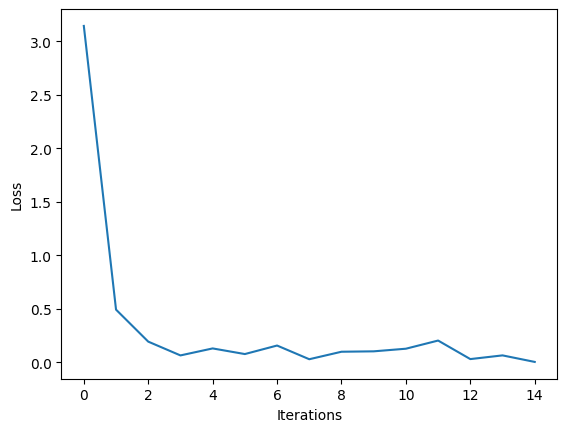

In [86]:
net_dims = [784, 100, 100, 64, 10] # This network has 4 layers
drop_prob_list = [0, 0, 0, 0]
bnorm_list = [1,1,1,1]
assert(len(bnorm_list) == len(net_dims)-1)
act_list = ['relu', 'relu', 'relu', 'linear']
assert(len(act_list) == len(net_dims)-1)

num_epochs = 3
batch_size = 64
learning_rate = 1e-2
decay_rate = 1
apply_momentum = True

costs, parameters = multi_layer_network(X_train, y_train, net_dims, act_list,
                                        drop_prob_list, bnorm_list,
                                        num_epochs=num_epochs,
                                        batch_size=batch_size,
                                        learning_rate=learning_rate,
                                        decay_rate=decay_rate,
                                        apply_momentum=apply_momentum,
                                        log=True)

train_Pred = classify(X_train, parameters)

test_Pred = classify(X_test, parameters)

trAcc = np.mean(train_Pred == y_train)*100
teAcc = np.mean(test_Pred == y_test)*100


print("Training Accuracy: {0:0.3f} %".format(trAcc))
print("Testing Accuracy {0:0.3f} %".format(teAcc))

plt.plot(range(len(costs)),costs)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()